In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor


# Reading the DB and Randomizing Indexes

In [2]:
data=pd.read_csv("./paris_airbnb.csv")
np.random.seed(1)
random_indices = np.random.permutation(data.index)
paris_listings = data.loc[random_indices]

## Data cleaning 

In [3]:
paris_listings['price'] = paris_listings['price'].str.replace(',', '').str.replace('$', '').astype(float)
paris_listings.drop(['room_type','city','state','longitude','latitude','zipcode','host_response_rate','host_acceptance_rate','host_listings_count'],axis=1,inplace=True)
missing_values_sum = paris_listings.isna().sum()
print("Missing SUM : ",missing_values_sum)
paris_listings.drop(['cleaning_fee','security_deposit'],axis=1,inplace=True)
paris_listings.dropna(subset=['bedrooms','bathrooms','beds'],inplace=True)
missing_values_sum = paris_listings.isna().sum()
print("##################################################")
print("Missing SUM : ",missing_values_sum)
print("##################################################")
print(paris_listings)

Missing SUM :  accommodates            0
bedrooms               24
bathrooms              58
beds                   14
price                   0
cleaning_fee         1750
security_deposit     1680
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64
##################################################
Missing SUM :  accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64
##################################################
      accommodates  bedrooms  bathrooms  beds  price  minimum_nights  \
4740             4       1.0        1.0   2.0   65.0               2   
5606             3       2.0        1.5   2.0   98.0               5   
4824             2       0.0        1.0   1.0   65.0              10   
4205             2       1.0        1.0   1.0   45.0               5   
3228             3       1.0        1.

C:\Users\csahm\AppData\Local\Temp\ipykernel_25856\4235164122.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  paris_listings['price'] = paris_listings['price'].str.replace(',', '').str.replace('$', '').astype(float)


### Normalizing Columns and Euclidean Distance 

In [4]:
normalized_listings = ((paris_listings - paris_listings.mean()) / paris_listings.std())
normalized_listings['price'] = paris_listings['price']
normalized_listings.head(3)
distance = np.sqrt(abs(normalized_listings['accommodates'][0] - normalized_listings['accommodates'][4])**2 + abs(normalized_listings['bedrooms'][0] - normalized_listings['bedrooms'][4])**2)
print(distance)

1.1894883046218971


In [5]:
scaler = StandardScaler()
features = paris_listings.drop(['price'], axis=1)
features_normalized = scaler.fit_transform(features)
print(features_normalized)

###Retrieve the price column
price = paris_listings['price'].values

features_normalized = pd.DataFrame(features_normalized, columns=features.columns)
normalized_listings = features_normalized.copy()
normalized_listings['price'] = price

[[ 0.50390016 -0.29690253 -0.29355565 ... -0.1846128   1.0629255
  -0.56458025]
 [-0.13185722  0.8926609   0.84402636 ... -0.10118931  1.06108519
  -0.63696468]
 [-0.76761461 -1.48646597 -0.29355565 ...  0.03784984  1.0629255
  -0.65144157]
 ...
 [-0.76761461 -1.48646597 -0.29355565 ... -0.1846128   1.0629255
  -0.6224878 ]
 [ 1.77541493  0.8926609  -0.29355565 ... -0.1846128  -0.96140958
   0.76729322]
 [-0.76761461 -0.29690253 -0.29355565 ... -0.15680497 -0.9706111
  -0.65144157]]


### Split the data into train and test sets

In [6]:
X = normalized_listings.drop('price', axis=1)
y = normalized_listings['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Tuning Hyperparameters for a KNN Model with GridSearchCV

In [7]:
knn_model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(knn_model, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search_knn.fit(X_train, y_train)

best_params_knn = grid_search_knn.best_params_
print("Best params for KNN  : ", best_params_knn)



Best params for KNN  :  {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


### Visualisation

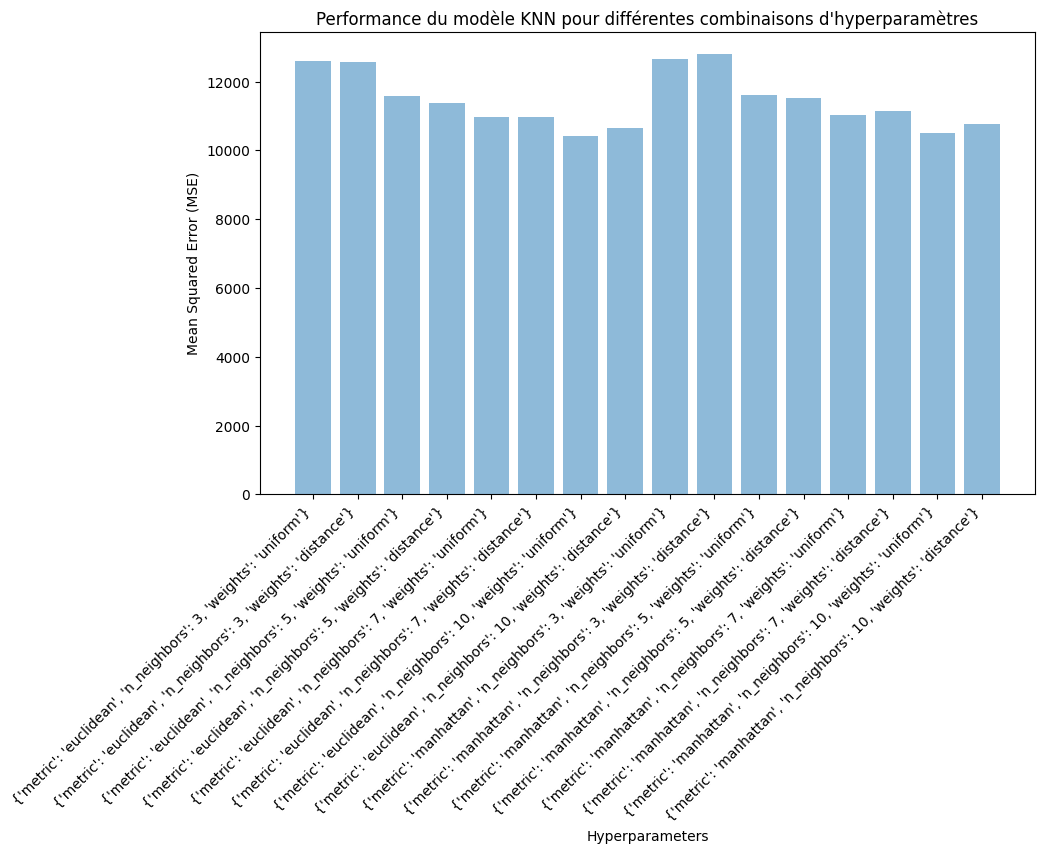

In [8]:
import matplotlib.pyplot as plt

results = grid_search_knn.cv_results_
params = results['params']
mean_mse = -results['mean_test_score']

plt.figure(figsize=(10, 6))
plt.bar(range(len(params)), mean_mse, align='center', alpha=0.5)
plt.xticks(range(len(params)), [str(param) for param in params], rotation=45, ha='right')
plt.xlabel('Hyperparameters')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Performance du modèle KNN pour différentes combinaisons d\'hyperparamètres')
plt.show()


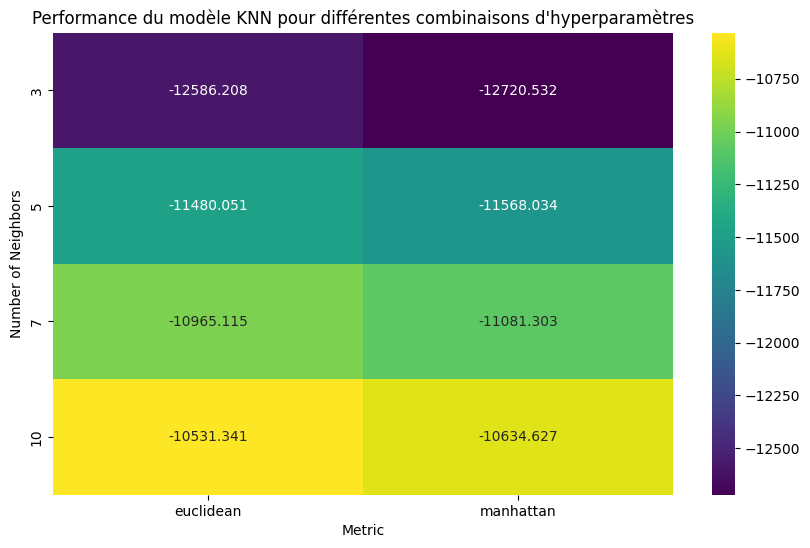

In [9]:
import seaborn as sns

results_df = pd.DataFrame(results)

pivot_table = results_df.pivot_table(values='mean_test_score', index='param_n_neighbors', columns='param_metric')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='viridis')
plt.title('Performance du modèle KNN pour différentes combinaisons d\'hyperparamètres')
plt.xlabel('Metric')
plt.ylabel('Number of Neighbors')
plt.show()


### The Best Hyperparameters to Train a KNN Model

In [10]:
from sklearn.neighbors import KNeighborsRegressor


best_n_neighbors = best_params_knn['n_neighbors']
best_weights = best_params_knn['weights']
best_metric = best_params_knn['metric']

knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
print(X_test.sample(1))
mse = mean_squared_error(y_test, y_pred)
print("Erreur quadratique moyenne (MSE) : ", mse)



      accommodates  bedrooms  bathrooms      beds  minimum_nights  \
2889     -0.767615 -1.486466  -0.293556 -0.645301       -0.156805   

      maximum_nights  number_of_reviews  
2889        -0.84179          -0.390858  
Erreur quadratique moyenne (MSE) :  5682.50691919192


### Actual vs. Predicted Values Plot



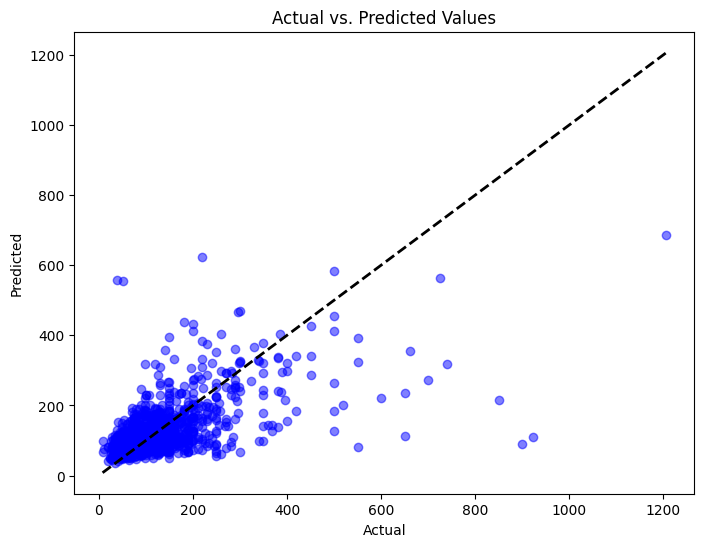

In [11]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual target values and y_pred contains the predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()


### Residual Plot:


###### Plot the residuals (the differences between actual and predicted values) against the predicted values. This can help you identify patterns or trends in the residuals, which can indicate issues with the model.

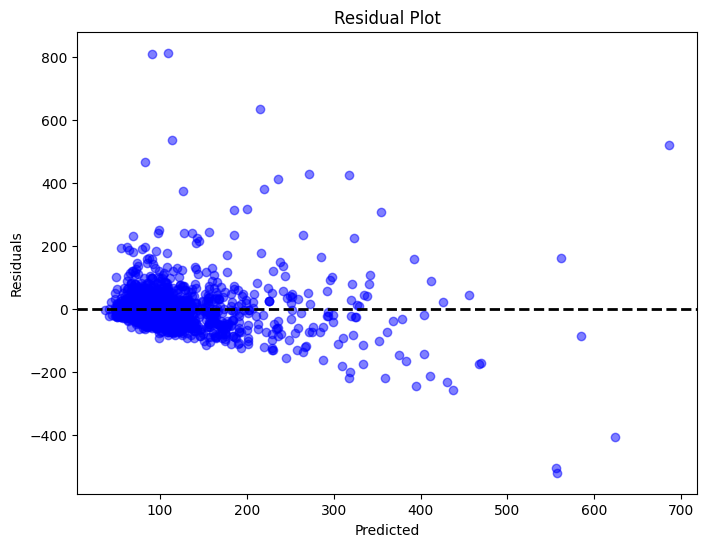

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test - y_pred, color='blue', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
